<a href="https://colab.research.google.com/github/Sathush3/collab/blob/main/transferlearningPestDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
!nvidia-smi

Sun Jul 10 14:24:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Dataset Download

unzip and set the directories

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks'

In [ ]:
import os
import zipfile
base_dir = '/content/pest/dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

loading training and validation dataset

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

Adjust batch size here for tuning


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_dir = 'fy/train'
#validDir = 'fy/valid'
testDir = 'fy/train'

IMG_SIZE = 224
BATCH_SIZE = 512

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  seed=123,
  subset="training",
  image_size=(224, 224),
  batch_size=BATCH_SIZE,
  
  )
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(224, 224),
  batch_size=BATCH_SIZE
  )

View the class name and first 10 images of each class

In [ ]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Autotune


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation


data augmentation by random flipping
When you apply augmentation to a training set, you’re preventing overfitting, because augmentation exposes different aspects of the image to the model.

In [ ]:
data_augmentation = keras.Sequential(
    [       keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
   keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

checking result of the augmentaion

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
for images, labels in training_set.take(1):
    plt.figure(figsize=(12, 12))
    first_image = images[0]
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0)
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")

# Creating a base model from pre-trained models


using the model trained on imagenet dataset
`include_top=False` means that we're not interested in the last layer of the model. Since models are visualized from bottom to top, that layer is referred to as the top layer. Excluding the top layers is important for feature extraction.

In [ ]:
base_model = keras.applications.MobileNetV3Large(
    weights='imagenet',  
    input_shape=(224, 224, 3),
    include_top=False) 

12697600/12683000 [==============================] - 0s 0us/step


In [ ]:
base_model = keras.applications.InceptionV3(
    weights='imagenet',  
    input_shape=(224, 224, 3),
    include_top=False) 

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
base_model = keras.applications.ResNet50(
    weights='imagenet',  
    input_shape=(224, 224, 3),
    include_top=False) 

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
base_model = keras.applications.DenseNet121(
    weights='imagenet',  
    input_shape=(224, 224, 3),
    include_top=False) 

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
base_model = keras.applications.NASNetMobile(
    weights='imagenet',  
    input_shape=(224, 224, 3),
    include_top=False) 

20004864/19993432 [==============================] - 0s 0us/step


In [ ]:
!pip install git+https://github.com/rcmalli/keras-squeezenet.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rcmalli/keras-squeezenet.git to /tmp/pip-req-build-b6xb055w
  Running command git clone -q https://github.com/rcmalli/keras-squeezenet.git /tmp/pip-req-build-b6xb055w
  Created wheel for keras-squeezenet: filename=keras_squeezenet-0.4-py3-none-any.whl size=4435 sha256=5e36d8bc06051c036ff4568074e7df339a4b4e75043a68677009a1783d315a06
  Stored in directory: /tmp/pip-ephem-wheel-cache-ogj5waix/wheels/30/c8/6f/e0ccdc0b275ae53ec21e2d65b172dc970202111a7cd5b66c32
Successfully built keras-squeezenet


In [ ]:
import numpy as np
from keras_squeezenet import SqueezeNet
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image
base_model=SqueezeNet(include_top=False, 
                      weights='imagenet',
                      input_shape=(224, 224, 3),
                      include_top=False)

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

freeze the base model layers so that they’re not updated during the training process. 

Since many pre-trained models have a `tf.keras.layers.BatchNormalization` layer, it’s important to freeze those layers. Otherwise, the layer mean and variance will be updated, which will destroy what the model has already learned. 

In [ ]:
base_model.trainable = False

# Feature extraction

 By specifying the include_top=False argument, we load a network which doesn't include the classification layers at the top, which is ideal for feature extraction.
This feature extractor converts each 224x224x3 image into a 5x5x1280 block of features

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# Create the final dense layer

When loading the model, you used `include_top=False` meaning that the final dense layer of the pre-trained model wasn’t included. 
so we need define a final output layer for this model. 

In [ ]:
#inputs = keras.Input(shape=(224, 224, 3))
img_shape = (IMG_SIZE, IMG_SIZE, 3)
inputs = Input(img_shape)
num_classes = 10

apply data augmentation

In [ ]:
outputs = data_augmentation(inputs)

# Preprocess using model's built in preprocessor

use various but almost similar

In [ ]:
outputs = tf.keras.applications.mobilenet_v3.preprocess_input(outputs)

In [ ]:
outputs = tf.keras.applications.resnet50.preprocess_input(outputs)

In [ ]:
outputs = tf.keras.applications.densenet.preprocess_input(outputs)

In [ ]:
outputs = tf.keras.applications.inception_v3.preprocess_input(outputs)

# Define Model


ensure that the base model is running in inference mode so that batch normalization layers are not updated during the fine-tuning stage (set `training=False`);
convert features from the base model to vectors, using `GlobalAveragePooling2D`;
apply dropout regularization;
add a final dense layer (when you used `include_top=False,` the final output layer was not included,so we have to define our own).

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

In [ ]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation = 'relu')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

In [ ]:
outputs = base_model(outputs, training=False)
outputs = global_average_layer(outputs)
outputs = keras.layers.Dropout(0.5)(outputs)  
outputs = prediction_layer(outputs)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy,metrics=keras.metrics.BinaryAccuracy())


In [ ]:
model.summary()

# Train the model

train the top layer
accuracy starts high coz pre trained model
adjust the epochs learning rate here

initial accuracy check

In [ ]:
loss0, accuracy0 = model.evaluate(val_ds)

In [ ]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/20
4/4 [==============================] - 26s 2s/step - loss: 0.6637 - binary_accuracy: 0.6035 - val_loss: 0.6123 - val_binary_accuracy: 0.6060
Epoch 2/20
4/4 [==============================] - 6s 1s/step - loss: 0.6569 - binary_accuracy: 0.6045 - val_loss: 0.5855 - val_binary_accuracy: 0.6190
Epoch 3/20
4/4 [==============================] - 6s 1s/step - loss: 0.6248 - binary_accuracy: 0.6270 - val_loss: 0.5615 - val_binary_accuracy: 0.6350
Epoch 4/20
4/4 [==============================] - 6s 1s/step - loss: 0.5993 - binary_accuracy: 0.6520 - val_loss: 0.5400 - val_binary_accuracy: 0.6460
Epoch 5/20
4/4 [==============================] - 6s 1s/step - loss: 0.5991 - binary_accuracy: 0.6545 - val_loss: 0.5206 - val_binary_accuracy: 0.6590
Epoch 6/20
4/4 [==============================] - 6s 1s/step - loss: 0.5719 - binary_accuracy: 0.6580 - val_loss: 0.5026 - val_binary_accuracy: 0.6730
Epoch 7/20
4/4 [==============================] - 6s 1s/step - loss: 0.5599 - binary_accuracy

testing confus matrix


In [ ]:
y_pred = model.predict(val_ds)

y_pred

array([[-8.3788067e-01],
       [ 5.1813936e-01],
       [-2.3731692e+00],
       [-2.6287225e-01],
       [ 1.1672027e+00],
       [ 8.9357591e-01],
       [ 8.5132819e-01],
       [-1.0383384e+00],
       [-1.4571587e+00],
       [ 1.8570966e+00],
       [ 5.6842935e-01],
       [ 1.1212797e+00],
       [-2.8532705e+00],
       [-2.7145660e+00],
       [ 1.4238442e+00],
       [-2.4175034e+00],
       [-2.0849640e+00],
       [-2.5579410e+00],
       [-9.6461898e-01],
       [ 1.3371340e+00],
       [ 1.4002873e+00],
       [ 1.5172795e+00],
       [-1.7659622e+00],
       [ 3.1561413e-01],
       [-1.7918842e+00],
       [ 8.2511467e-01],
       [ 9.2633706e-01],
       [ 2.4738417e+00],
       [ 3.2829633e-01],
       [-1.9572945e+00],
       [-3.4575069e-01],
       [-1.5290214e-01],
       [-5.2916938e-01],
       [-1.9859804e-01],
       [-3.0188589e+00],
       [-1.5758433e+00],
       [-1.3448572e+00],
       [-9.3669021e-01],
       [ 1.1567308e+00],
       [ 2.2009530e+00],


In [ ]:
predicted_categories = tf.argmax(y_pred, axis=1)

In [ ]:
true_categories = tf.concat([y for x, y in val_ds], axis=0)

In [ ]:
cf_matrix=confusion_matrix(predicted_categories, true_categories)

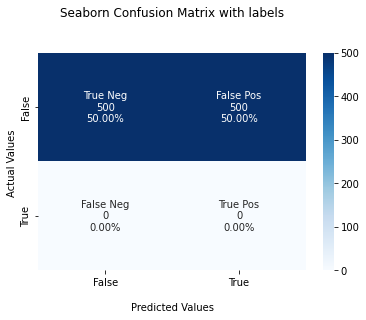

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

learning curves

In [ ]:
acc = model.history['accuracy']
val_acc = model.history['val_accuracy']

loss = model.history['loss']
val_loss = model.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine-tuning the model

The model can be improved by unfreezing the base model, and retraining it on a very low learning rate. 

You need to monitor this step because the wrong implementation can lead to overfitting

In [ ]:
base_model.trainable = True

After updating the trainable attribute, the model has to be compiled again to implement the change.

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),  
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=keras.metrics.BinaryAccuracy())

To prevent overfitting, let’s monitor training loss via a callback. Keras will stop training when the model doesn’t improve for five consecutive epochs. Let’s also use TensorBoard to monitor loss and accuracy.

In [ ]:
rm -rf logs

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

%load_ext tensorboard
log_folder = 'logs'
callbacks = [
            EarlyStopping(patience = 5),
            TensorBoard(log_dir=log_folder)
            ]

retrain the model.

chnge the epoch and learning rate

In [ ]:
model.fit(train_ds, epochs=75,validation_data=val_ds,callbacks=callbacks)

Epoch 1/15
63/63 [==============================] - 17s 147ms/step - loss: 0.0575 - binary_accuracy: 0.9750 - val_loss: 0.0733 - val_binary_accuracy: 0.9670
Epoch 2/15
63/63 [==============================] - 8s 123ms/step - loss: 0.0447 - binary_accuracy: 0.9830 - val_loss: 0.0711 - val_binary_accuracy: 0.9690
Epoch 3/15
63/63 [==============================] - 8s 127ms/step - loss: 0.0429 - binary_accuracy: 0.9800 - val_loss: 0.0718 - val_binary_accuracy: 0.9680
Epoch 4/15
63/63 [==============================] - 8s 124ms/step - loss: 0.0385 - binary_accuracy: 0.9865 - val_loss: 0.0684 - val_binary_accuracy: 0.9730
Epoch 5/15
63/63 [==============================] - 8s 124ms/step - loss: 0.0386 - binary_accuracy: 0.9845 - val_loss: 0.0662 - val_binary_accuracy: 0.9710
Epoch 6/15
63/63 [==============================] - 8s 124ms/step - loss: 0.0339 - binary_accuracy: 0.9860 - val_loss: 0.0671 - val_binary_accuracy: 0.9710
Epoch 7/15
63/63 [==============================] - 8s 125ms/st

# save model as tflite


In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)